<a href="https://colab.research.google.com/github/jsebastianquiroga/analitica_ia_puj/blob/main/Analitica_2/04_caso_de_negocio_DNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Caso de Negocio -- Scholastic Travel Company

La agencia de viajes Scholastic Travel Company desea crear una estrategia de retención de clientes. Para esto, es necesario que el equipo de analítica cree un modelo de predicción para determinar qué clientes de los que viajaron el año anterior (2011) van a reservar nuevamente el año siguiente (2012). 

En este Notebook se trabajarán los siguientes temas: 

- Separación de Datos en Train/Val/Test
- Análisis de Correlaciones
- Ajuste del mejor SVM 
- Métricas de Evaluación

In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC

A continuación se carga la base de datos de STC, que cuenta con 2389 registros de clientes que viajaron en 2011 y tiene una variable que determina si el cliente viajó nuevamente en 2012. 

In [17]:
import pandas as pd
# Conexion a gdrive
from pydrive.auth import GoogleAuth
from google.colab import drive
from pydrive.drive import GoogleDrive
from google.colab import auth

from oauth2client.client import GoogleCredentials

In [18]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

datos = '19yTB5VC-tU59-yBwTLxt2NHNVS0BLWnS' 
download = drive.CreateFile({'id': datos}) 
download.GetContentFile('STC_datos_grupos.csv')

df = pd.read_csv('STC_datos_grupos.csv', sep = ';')
print('Dimencion : ', df.shape)

df = df.drop(columns = ['FirstMeeting', 'LastMeeting', 'Initial.System.Date', 'Early.RPL', 'Latest.RPL', 'Departure.Date', 'Return.Date', 'Deposit.Date'])

df.head()

Dimencion :  (2389, 56)


,ID,Program.Code,From.Grade,To.Grade,Group.State,Is.Non.Annual.,Days,Travel.Type,Special.Pay,Tuition,...,GroupGradeTypeLow,GroupGradeTypeHigh,GroupGradeType,MajorProgramCode,SingleGradeTripFlag,FPP.to.School.enrollment,FPP.to.PAX,Num.of.Non_FPP.PAX,SchoolSizeIndicator,Retained.in.2012.
0,1,HS,4.0,4.0,CA,0,1,A,NaN,424,...,K,Elementary,K->Elementary,H,1,0.06364617,0.936508,4,L,1
1,2,HC,8.0,8.0,AZ,0,7,A,CP,2350,...,Middle,Middle,Middle->Middle,H,1,0.025882353,0.880000,3,L,1
2,3,HD,8.0,8.0,FL,0,3,A,NaN,1181,...,Middle,Middle,Middle->Middle,H,1,0.02513089,0.888889,3,L,1
3,4,HN,9.0,12.0,VA,1,3,B,NaN,376,...,Undefined,Undefined,Undefined->Undefined,H,0,NaN,1.000000,0,NaN,0
4,5,HD,6.0,8.0,FL,0,6,T,NaN,865,...,Middle,Middle,Middle->Middle,H,0,0.1125,0.910112,8,M-L,0


Se cuenta con 54 variables independientes y una variable explicativa, `Retained.in.2012.`. 

In [19]:
df.columns

Index(['ID', 'Program.Code', 'From.Grade', 'To.Grade', 'Group.State',
       'Is.Non.Annual.', 'Days', 'Travel.Type', 'Special.Pay', 'Tuition',
       'FRP.Active', 'FRP.Cancelled', 'FRP.Take.up.percent.', 'Cancelled.Pax',
       'Total.Discount.Pax', 'Poverty.Code', 'Region', 'CRM.Segment',
       'School.Type', 'Parent.Meeting.Flag', 'MDR.Low.Grade', 'MDR.High.Grade',
       'Total.School.Enrollment', 'Income.Level', 'EZ.Pay.Take.Up.Rate',
       'School.Sponsor', 'SPR.Product.Type', 'SPR.New.Existing', 'FPP',
       'Total.Pax', 'SPR.Group.Revenue', 'NumberOfMeetingswithParents',
       'DifferenceTraveltoFirstMeeting', 'DifferenceTraveltoLastMeeting',
       'SchoolGradeTypeLow', 'SchoolGradeTypeHigh', 'SchoolGradeType',
       'DepartureMonth', 'GroupGradeTypeLow', 'GroupGradeTypeHigh',
       'GroupGradeType', 'MajorProgramCode', 'SingleGradeTripFlag',
       'FPP.to.School.enrollment', 'FPP.to.PAX', 'Num.of.Non_FPP.PAX',
       'SchoolSizeIndicator', 'Retained.in.2012.'],
      

## Importamos Datos de NPS

Adicional a los datos de los cursos que viajaron el año inmediatamente anterior, se tiene información de NPS de los cursos que viajaron años atrás. Esta información puede ser útil para entender por qué algunos siguen viajando o dejan de viajar.

In [20]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

nps = '1zx0LkJUxQaB6rmpiT9X7gNIeL4Qufp3Q' 
download = drive.CreateFile({'id': nps}) 
download.GetContentFile('nps_complementaria.csv')

nps_df = pd.read_csv('nps_complementaria.csv', sep = ';')
print('Dimencion : ', nps_df.shape)

nps_df[['NPS 2011', 'NPS 2010', 'NPS 2009', 'NPS 2008']] = nps_df[['NPS 2011', 'NPS 2010', 'NPS 2009', 'NPS 2008']].apply(pd.to_numeric, errors='coerce')

nps_df.head()


Dimencion :  (2389, 9)


,ID,NPS 2011,NPS 2010,NPS 2009,NPS 2008,>= 3 FPP Date,>= 10 FPP Date,>= 20 FPP Date,>= 35 FPP Date
0,1,10.0,10.0,10.0,10.0,40335.0,40347.0,40407.0,40420.0
1,2,9.0,10.0,10.0,NaN,40162.0,40198.0,40329.0,NaN
2,3,NaN,10.0,10.0,NaN,40338.0,40338.0,40477.0,NaN
3,4,10.0,NaN,10.0,NaN,40549.0,40549.0,NaN,NaN
4,5,10.0,NaN,10.0,NaN,40311.0,40322.0,40325.0,40330.0


In [21]:
pd.DataFrame(nps_df.isna().sum()/len(nps_df))

,0
ID,0.000000
NPS 2011,0.241524
NPS 2010,0.514441
NPS 2009,0.512767
NPS 2008,0.591042
>= 3 FPP Date,0.003767
>= 10 FPP Date,0.171201
>= 20 FPP Date,0.428631
>= 35 FPP Date,0.677271


Podemos observar que aunque existen valores faltantes, el NPS de cada año sigue un patrón similar. Se concentra fuertemente en promotores. De hecho, puede que lo que nos indique es que los promotores son quienes se quedan y los detractores se van. 

Eso sumado al análisis que habíamos hecho anteriormente.

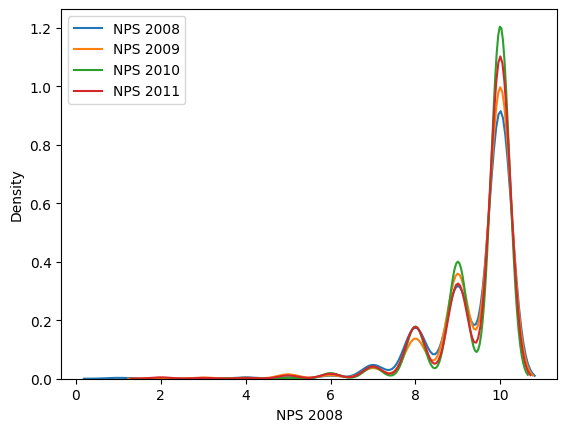

In [22]:
sns.kdeplot(nps_df['NPS 2008'], label = 'NPS 2008')
sns.kdeplot(nps_df['NPS 2009'], label = 'NPS 2009')
sns.kdeplot(nps_df['NPS 2010'], label = 'NPS 2010')
sns.kdeplot(nps_df['NPS 2011'], label = 'NPS 2011')
plt.legend()



### Creación de una variable nueva de NPS

Existen cuatro variables de NPS con datos faltantes, de hasta la mitad. En principio, no quisiéramos perder esa información, ¡y menos descartar todas las observaciones! 

Por esto, se propone crear una variable que reúna el NPS que cada institución le dio a STC en las últimas encuestas. Para esto, haremos uso de la mediana del NPS de los años anteriores.

In [23]:
nps_df['Median NPS'] = nps_df[['NPS 2011', 'NPS 2010', 'NPS 2009', 'NPS 2008']].apply(np.nanmedian, axis=1)


/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


<Axes: xlabel='Median NPS', ylabel='Density'>

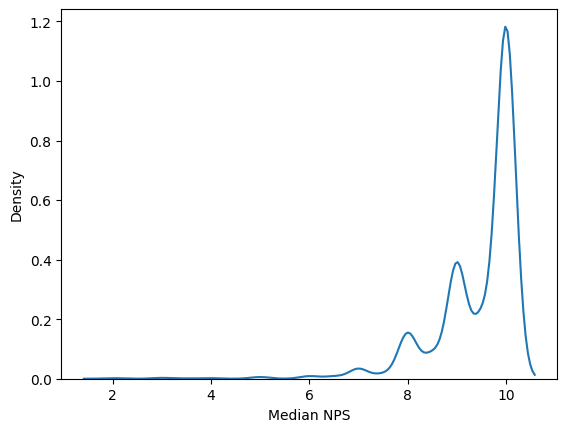

In [24]:
sns.kdeplot(nps_df['Median NPS']) # Tiene el mismo comportamiento

In [25]:
df.columns

Index(['ID', 'Program.Code', 'From.Grade', 'To.Grade', 'Group.State',
       'Is.Non.Annual.', 'Days', 'Travel.Type', 'Special.Pay', 'Tuition',
       'FRP.Active', 'FRP.Cancelled', 'FRP.Take.up.percent.', 'Cancelled.Pax',
       'Total.Discount.Pax', 'Poverty.Code', 'Region', 'CRM.Segment',
       'School.Type', 'Parent.Meeting.Flag', 'MDR.Low.Grade', 'MDR.High.Grade',
       'Total.School.Enrollment', 'Income.Level', 'EZ.Pay.Take.Up.Rate',
       'School.Sponsor', 'SPR.Product.Type', 'SPR.New.Existing', 'FPP',
       'Total.Pax', 'SPR.Group.Revenue', 'NumberOfMeetingswithParents',
       'DifferenceTraveltoFirstMeeting', 'DifferenceTraveltoLastMeeting',
       'SchoolGradeTypeLow', 'SchoolGradeTypeHigh', 'SchoolGradeType',
       'DepartureMonth', 'GroupGradeTypeLow', 'GroupGradeTypeHigh',
       'GroupGradeType', 'MajorProgramCode', 'SingleGradeTripFlag',
       'FPP.to.School.enrollment', 'FPP.to.PAX', 'Num.of.Non_FPP.PAX',
       'SchoolSizeIndicator', 'Retained.in.2012.'],
      

In [26]:
df = df.merge(nps_df[['ID', 'Median NPS']], on = 'ID', how = 'left')

In [27]:
del df['ID']

# Limpieza de Datos

Nos entregan una base de datos que tiene demasiadas variables categóricas que pueden o no aportar información para el modelo. A continuación se limpiarán las categorías y se hará imputación de datos en caso de que haya variables faltantes. 

In [28]:
## Asignación de tipos categóricos

categorical_features = ['From.Grade', 'To.Grade', 'Group.State', 'Travel.Type', 'Poverty.Code', 'CRM.Segment', 'School.Type', 'Parent.Meeting.Flag', 
                        'MDR.High.Grade', 'School.Sponsor', 'SchoolGradeTypeLow', 'SchoolGradeTypeHigh', 'GroupGradeTypeLow', 'GroupGradeTypeHigh',
                        'MajorProgramCode', 'SingleGradeTripFlag', 'SchoolSizeIndicator', 'Region', 'Special.Pay',    
                        'Income.Level', 'SPR.Product.Type', 'SPR.New.Existing', 'DepartureMonth', 'MDR.Low.Grade', 
                        'FPP.to.School.enrollment', 'GroupGradeType', 'Program.Code', 'SchoolGradeType']

df[categorical_features] = df[categorical_features].apply(lambda x: x.astype('category'))



## División en Train y Test

Antes de comenzar con la limpieza de datos (que es inputación de missing values, estandarizaciones, etc...) es importante realizar la división en train-test. No queremos codificar en los datos de entrenamiento información de los datos de prueba... 

Para esto, utilice la función de [`sklearn.model_selection.train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html).

In [29]:
y = df['Retained.in.2012.']
X = df.drop(columns = 'Retained.in.2012.')

### Utilice train_test_split para dividir los datos en entrenamiento y test. 

# Deje que el tamaño de test sea de 30%
# Random Sate: 42 para fines comparativos
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)
                                                    
###

Verifique que la concentración de la variable dependiente sea similar en la base de entrenamiento y en la de validación.

In [30]:
y_test.value_counts()/len(y_test)

1    0.589958
0    0.410042
Name: Retained.in.2012., dtype: float64

In [31]:
y_train.value_counts()/len(y_train)

1    0.616239
0    0.383761
Name: Retained.in.2012., dtype: float64

## Missing Values

A continuación se realizará la inputación de valores faltantes. Utilizando el método `X_train.isna().sum()`

In [32]:
pd.DataFrame(X_train.isna().sum()/len(X_train))

,0
Program.Code,0.000000
From.Grade,0.053846
To.Grade,0.062393
Group.State,0.000000
Is.Non.Annual.,0.000000
Days,0.000000
Travel.Type,0.000000
Special.Pay,0.794872
Tuition,0.000000
FRP.Active,0.000000


Se observa que hay pocas columnas con valores faltantes. El 14% de los datos de entrenamiento no tuvo reuniones de padres, y el 25% no tiene asignado un código de pobreza. Es importante inputar los valores faltantes para poder realizar el entrenamiento. 

Utilice el método de [`sklearn.impute.SimpleImputer`](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html) para entrenar un imputador para variables categóricas y variables numéricas. 


In [33]:
categorical_columns = X_train.select_dtypes(exclude = [int, float]).columns
numerical_columns = X_train.select_dtypes(include = [int, float]).columns

### Imputador de Variables Categóricas -- strategy -> constant
from sklearn.impute import SimpleImputer
categorical_imputer = SimpleImputer(missing_values=np.nan, strategy='constant')
###

In [34]:
### Imputador de Variables Numéricas -- strategy -> Median
numerical_imputer = SimpleImputer(missing_values=np.nan, strategy='median')
###

In [35]:
categorical_imputer.fit(X_train[categorical_columns])

SimpleImputer(strategy='constant')

In [36]:
numerical_imputer.fit(X_train[numerical_columns])

SimpleImputer(strategy='median')

In [37]:
# Utilice los imputers para inputar valores faltantes tanto en train como en test

###
X_train[categorical_columns] = categorical_imputer.transform(X_train[categorical_columns])
X_val[categorical_columns] = categorical_imputer.transform(X_val[categorical_columns])
X_test[categorical_columns] = categorical_imputer.transform(X_test[categorical_columns])

X_train[numerical_columns] = numerical_imputer.transform(X_train[numerical_columns])
X_val[numerical_columns] = numerical_imputer.transform(X_val[numerical_columns])
X_test[numerical_columns] = numerical_imputer.transform(X_test[numerical_columns])
###

In [38]:
# Verifique que efectivamente no tenga valores faltantes

###
pd.DataFrame(X_train.isna().sum()/len(X_train))

###

,0
Program.Code,0.0
From.Grade,0.0
To.Grade,0.0
Group.State,0.0
Is.Non.Annual.,0.0
Days,0.0
Travel.Type,0.0
Special.Pay,0.0
Tuition,0.0
FRP.Active,0.0


## Revisión Categorías

En la base de datos existe un gran número de variables categóricas. Se debe decidir de qué manera codificar la información (si requiere) para que el modelo pueda utilizarla. 

En principio, note que hay variables en las que hay categorías con pocas observaciones. Por ejemplo, la variable `From.Grade` tiene los siguientes conteos:


|               |   From.Grade |
|:--------------|-------------:|
| 8.0           |          786 |
| 7.0           |          365 |
| 6.0           |          159 |
| 4.0           |          109 |
| missing_value |           91 |
| 5.0           |           67 |
| 9.0           |           47 |
| 11.0          |           19 |
| 10.0          |           19 |
| 12.0          |            5 |
| 3.0           |            5 |

Se puede apreciar que la categoría 3 y 12 tienen 5 observaciones. Lo ideal es agrupar las categorías que tienen menos observaciones en una nueva categoría como "Otra".

In [39]:
for column in categorical_columns:
  categorical_counts = pd.value_counts(X_train[column])
  grouper = (categorical_counts/categorical_counts.sum() * 100).lt(2) # Selecciona aquellas con < 2% de observaciones
  X_train[column] = np.where(X_train[column].isin(categorical_counts[grouper].index),'Otra',X_train[column]) # Reemplaza en columna original
  X_val[column] = np.where(X_val[column].isin(categorical_counts[grouper].index),'Otra',X_val[column])
  X_test[column] = np.where(X_test[column].isin(categorical_counts[grouper].index),'Otra',X_test[column])

In [40]:
X_train['From.Grade'].value_counts()

8.0              547
7.0              243
6.0              112
4.0               84
missing_value     63
5.0               49
9.0               37
Otra              35
Name: From.Grade, dtype: int64

## Variables Dummies

Algunas de las variables categóricas necesitan ser codificadas para poder entrar al modelo. Particularmente aquellas categorías que no son ordinales, como los estados donde se ubican los colegios. Por esta razón, utilizaremos One-Hot Encoding, para volver una variable categórica en un conjunto de variables binarias.


<div class="alert alert-block alert-danger">
<b>Cuidado:</b> Utilizar un número excesivo de variables dummies puede afectar negativamente el desempeño del modelo.
</div>

In [41]:
X_train = pd.get_dummies(X_train, columns = categorical_columns, drop_first = True)
X_val = pd.get_dummies(X_val, columns = categorical_columns, drop_first = True) # Pero igual debemos asegurarnos que no haya "dummies de más"
X_test = pd.get_dummies(X_test, columns = categorical_columns, drop_first = True) 

<ipython-input-41-78b80be6525d>:1: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  X_train = pd.get_dummies(X_train, columns = categorical_columns, drop_first = True)
<ipython-input-41-78b80be6525d>:1: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  X_train = pd.get_dummies(X_train, columns = categorical_columns, drop_first = True)
<ipython-input-41-78b80be6525d>:1: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  X_train = pd.get_dummies(X_train, columns = categorical_columns, drop_first = True)
<ipython-input-41-78b80be6525d>:2: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  

In [42]:
X_train, X_val = X_train.align(X_val, fill_value = 0, axis = 1, join = 'left')
X_train, X_test = X_train.align(X_test, fill_value = 0, axis = 1, join = 'left')

In [43]:
X_train.head()

,Is.Non.Annual.,Days,Tuition,FRP.Active,FRP.Cancelled,FRP.Take.up.percent.,Cancelled.Pax,Total.Discount.Pax,Total.School.Enrollment,EZ.Pay.Take.Up.Rate,...,GroupGradeType_Undefined->Undefined,MajorProgramCode_H,MajorProgramCode_Otra,MajorProgramCode_S,SingleGradeTripFlag_1,FPP.to.School.enrollment_missing_value,SchoolSizeIndicator_M-L,SchoolSizeIndicator_S,SchoolSizeIndicator_S-M,SchoolSizeIndicator_missing_value
850,1.0,5.0,1998.0,18.0,4.0,0.487,8.0,2.0,168.0,0.297,...,0,0,0,0,0,0,0,1,0,0
42,1.0,6.0,2559.0,37.0,8.0,0.617,11.0,7.0,700.0,0.233,...,0,1,0,0,1,0,1,0,0,0
540,0.0,4.0,800.0,11.0,1.0,0.262,1.0,3.0,750.0,0.524,...,0,1,0,0,1,0,1,0,0,0
1257,0.0,5.0,1672.0,22.0,4.0,0.733,6.0,3.0,809.0,0.233,...,0,1,0,0,1,0,1,0,0,0
1072,0.0,5.0,2100.0,12.0,0.0,0.857,1.0,1.0,92.0,0.071,...,0,1,0,0,1,0,0,1,0,0


In [44]:
X_test.head()

,Is.Non.Annual.,Days,Tuition,FRP.Active,FRP.Cancelled,FRP.Take.up.percent.,Cancelled.Pax,Total.Discount.Pax,Total.School.Enrollment,EZ.Pay.Take.Up.Rate,...,GroupGradeType_Undefined->Undefined,MajorProgramCode_H,MajorProgramCode_Otra,MajorProgramCode_S,SingleGradeTripFlag_1,FPP.to.School.enrollment_missing_value,SchoolSizeIndicator_M-L,SchoolSizeIndicator_S,SchoolSizeIndicator_S-M,SchoolSizeIndicator_missing_value
1320,0.0,1.0,384.0,19.0,1.0,0.475,3.0,2.0,407.0,0.200,...,0,1,0,0,1,0,0,0,1,0
1412,0.0,5.0,2117.0,14.0,2.0,0.667,0.0,2.0,184.0,0.286,...,0,1,0,0,1,0,0,1,0,0
530,0.0,5.0,736.0,29.0,6.0,0.460,4.0,4.0,500.0,0.111,...,0,1,0,0,1,0,0,0,1,0
554,0.0,5.0,1799.0,13.0,2.0,0.929,3.0,1.0,761.0,0.071,...,0,1,0,0,1,0,1,0,0,0
229,0.0,3.0,1058.0,19.0,1.0,0.704,1.0,5.0,334.0,0.185,...,0,1,0,0,0,0,0,1,0,0


In [45]:
X_val.head()

,Is.Non.Annual.,Days,Tuition,FRP.Active,FRP.Cancelled,FRP.Take.up.percent.,Cancelled.Pax,Total.Discount.Pax,Total.School.Enrollment,EZ.Pay.Take.Up.Rate,...,GroupGradeType_Undefined->Undefined,MajorProgramCode_H,MajorProgramCode_Otra,MajorProgramCode_S,SingleGradeTripFlag_1,FPP.to.School.enrollment_missing_value,SchoolSizeIndicator_M-L,SchoolSizeIndicator_S,SchoolSizeIndicator_S-M,SchoolSizeIndicator_missing_value
451,0.0,5.0,2140.0,42.0,5.0,0.793,5.0,5.0,936.0,0.170,...,0,0,0,1,1,0,0,0,0,0
1157,1.0,6.0,2232.0,2.0,4.0,0.286,5.0,1.0,120.0,0.143,...,0,0,0,0,0,0,0,1,0,0
2014,0.0,8.0,1669.0,9.0,2.0,0.563,3.0,3.0,774.0,0.125,...,0,1,0,0,0,0,1,0,0,0
370,1.0,6.0,1968.0,19.0,2.0,0.679,2.0,2.0,275.0,0.250,...,0,0,0,0,0,0,0,1,0,0
1579,1.0,5.0,1101.0,11.0,1.0,0.611,1.0,2.0,290.0,0.222,...,0,1,0,0,0,0,0,1,0,0


En este punto, los datos de entrenamiento y prueba tienen las mismas características y están codificados de la misma forma basado en la información de entrenamiento. Con lo anterior, es posible entrenar los modelos que queramos para predicción.

# Red Neuronal

A continuación vamos a entrenar redes neuronales que nos permitan realizar el modelo de clasificación. Realizaremos dos modelos inicialmente:
- Modelo Base
- Modelo con Regularización

Adicionalmente, haremos uso del *Early Stopping* como se mencionó en clases anteriores para evitar que el modelo aprenda mal. 

## Métrica F1 para Modelo

In [46]:
import numpy as np
import tensorflow as tf
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred)
        self.recall.update_state(y_true, y_pred)

    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        f1_score = 2 * ((precision * recall) / (precision + recall + 1e-7))
        return f1_score

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()

## Modelo Sencillo

In [47]:
X_train.shape

(1170, 151)

In [48]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [49]:
model.compile(optimizer='adam', loss='binary_crossentropy',  metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), F1Score()])

In [50]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/100
36/37 [============================>.] - ETA: 0s - loss: 4.0823 - accuracy: 0.5998 - precision: 0.6741 - recall: 0.6807 - f1_score: 0.6774

/usr/local/lib/python3.10/dist-packages/keras/engine/training.py:2448: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


37/37 [==============================] - 2s 22ms/step - loss: 4.0537 - accuracy: 0.6000 - precision: 0.6750 - recall: 0.6768 - f1_score: 0.6759 - val_loss: 1.4242 - val_accuracy: 0.6215 - val_precision: 0.7407 - val_recall: 0.5863 - val_f1_score: 0.6545
Epoch 2/100
37/37 [==============================] - 0s 6ms/step - loss: 1.2282 - accuracy: 0.6085 - precision: 0.6804 - recall: 0.6879 - f1_score: 0.6841 - val_loss: 1.6511 - val_accuracy: 0.4801 - val_precision: 0.6949 - val_recall: 0.2671 - val_f1_score: 0.3859
Epoch 3/100
37/37 [==============================] - 0s 5ms/step - loss: 1.3950 - accuracy: 0.6179 - precision: 0.6892 - recall: 0.6921 - f1_score: 0.6907 - val_loss: 1.3520 - val_accuracy: 0.5219 - val_precision: 0.7055 - val_recall: 0.3746 - val_f1_score: 0.4894
Epoch 4/100
37/37 [==============================] - 0s 6ms/step - loss: 0.9825 - accuracy: 0.6564 - precision: 0.7231 - recall: 0.7171 - f1_score: 0.7201 - val_loss: 0.9237 - val_accuracy: 0.6235 - val_precision: 0.

In [51]:

def plot_metrics(history):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Plot the training and validation loss
    axes[0].plot(history.history['loss'], label='Training loss')
    axes[0].plot(history.history['val_loss'], label='Validation loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Training and Validation Loss')
    axes[0].legend()

    # Plot the training and validation accuracy
    axes[1].plot(history.history['accuracy'], label='Training accuracy')
    axes[1].plot(history.history['val_accuracy'], label='Validation accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].legend()
    

    # Plot the training and validation recall
    axes[2].plot(history.history.get('f1_score'), label='Training F1')
    axes[2].plot(history.history.get('val_f1_score'), label='Validation F1')
    axes[2].set_xlabel('Epochs')
    axes[2].set_ylabel('F1')
    axes[2].set_title('Training and Validation F1')
    axes[2].legend()

    fig.tight_layout()
    plt.show()




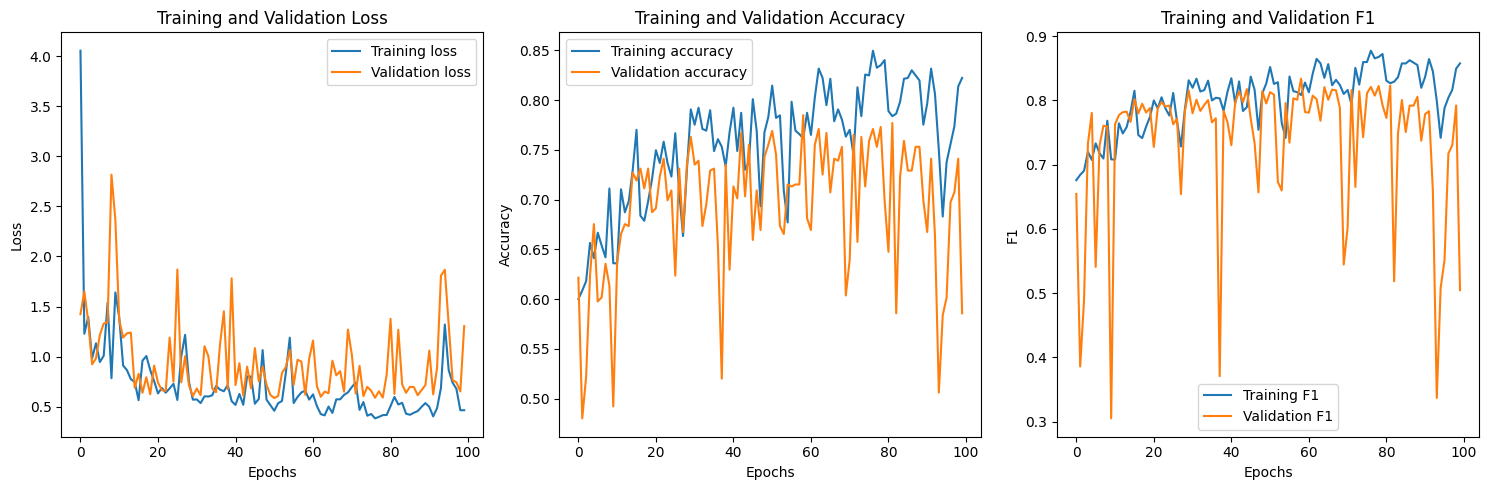

In [52]:
plot_metrics(history)

## Modelo con Dropout

In [53]:
model_dropout = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_dropout.compile(optimizer='adam', loss='binary_crossentropy',  metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), F1Score()])

In [54]:
dropout_history = model_dropout.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/100
22/37 [================>.............] - ETA: 0s - loss: 34.6207 - accuracy: 0.5085 - precision_2: 0.5923 - recall_2: 0.5839 - f1_score: 0.5881 

/usr/local/lib/python3.10/dist-packages/keras/engine/training.py:2448: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


37/37 [==============================] - 2s 15ms/step - loss: 26.5406 - accuracy: 0.5282 - precision_2: 0.6199 - recall_2: 0.6061 - f1_score: 0.6129 - val_loss: 3.6696 - val_accuracy: 0.6494 - val_precision_2: 0.6415 - val_recall_2: 0.9674 - val_f1_score: 0.7714
Epoch 2/100
37/37 [==============================] - 0s 5ms/step - loss: 10.8135 - accuracy: 0.5154 - precision_2: 0.6064 - recall_2: 0.6089 - f1_score: 0.6076 - val_loss: 3.9284 - val_accuracy: 0.4582 - val_precision_2: 0.6882 - val_recall_2: 0.2085 - val_f1_score: 0.3200
Epoch 3/100
37/37 [==============================] - 0s 4ms/step - loss: 7.0136 - accuracy: 0.5265 - precision_2: 0.6133 - recall_2: 0.6269 - f1_score: 0.6200 - val_loss: 2.6649 - val_accuracy: 0.4900 - val_precision_2: 0.7107 - val_recall_2: 0.2801 - val_f1_score: 0.4019
Epoch 4/100
37/37 [==============================] - 0s 5ms/step - loss: 4.6991 - accuracy: 0.5496 - precision_2: 0.6340 - recall_2: 0.6366 - f1_score: 0.6353 - val_loss: 1.0226 - val_accura

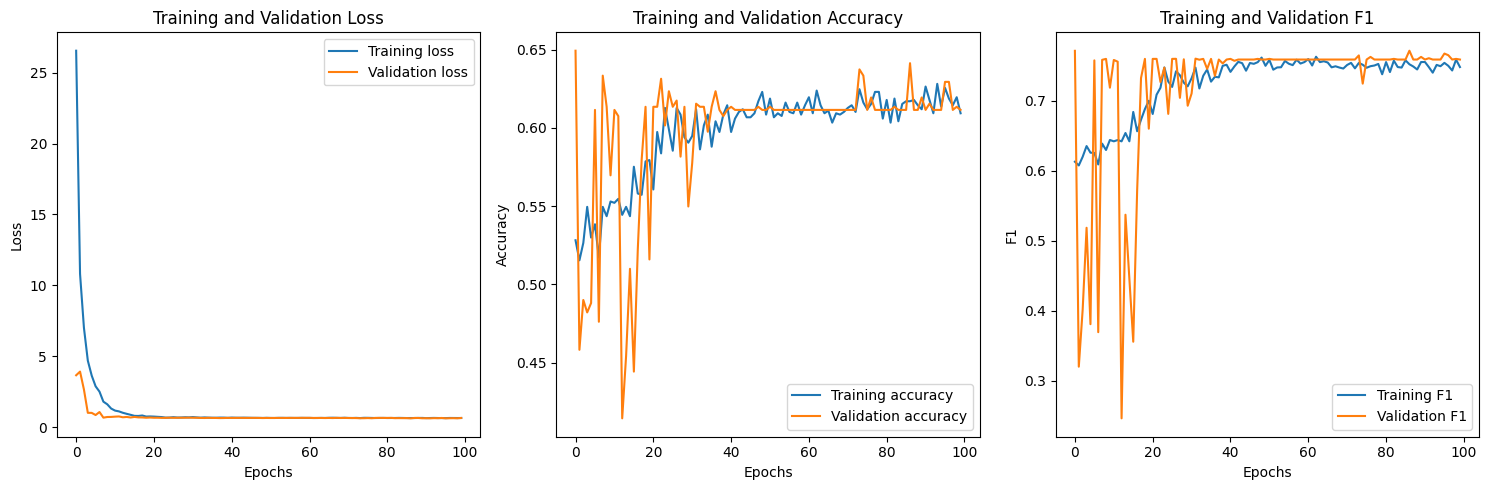

In [55]:
plot_metrics(dropout_history)

## Early Stopping

In [56]:
earlystopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15)


model_early = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_early.compile(optimizer='adam', loss='binary_crossentropy',  metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), F1Score()])

# Train the model and capture the training history
history_early = model_early.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks=[earlystopping_callback], verbose = 1)


Epoch 1/100
21/37 [================>.............] - ETA: 0s - loss: 41.8307 - accuracy: 0.5119 - precision_4: 0.5962 - recall_4: 0.6078 - f1_score: 0.6019              

/usr/local/lib/python3.10/dist-packages/keras/engine/training.py:2448: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


37/37 [==============================] - 2s 15ms/step - loss: 31.3176 - accuracy: 0.5179 - precision_4: 0.6107 - recall_4: 0.6006 - f1_score: 0.6056 - val_loss: 3.1232 - val_accuracy: 0.6116 - val_precision_4: 0.6116 - val_recall_4: 1.0000 - val_f1_score: 0.7590
Epoch 2/100
37/37 [==============================] - 0s 5ms/step - loss: 9.5699 - accuracy: 0.5265 - precision_4: 0.6184 - recall_4: 0.6047 - f1_score: 0.6115 - val_loss: 1.4152 - val_accuracy: 0.6474 - val_precision_4: 0.6816 - val_recall_4: 0.7948 - val_f1_score: 0.7338
Epoch 3/100
37/37 [==============================] - 0s 4ms/step - loss: 5.7135 - accuracy: 0.5316 - precision_4: 0.6220 - recall_4: 0.6117 - f1_score: 0.6168 - val_loss: 1.4061 - val_accuracy: 0.5578 - val_precision_4: 0.7202 - val_recall_4: 0.4528 - val_f1_score: 0.5560
Epoch 4/100
37/37 [==============================] - 0s 4ms/step - loss: 3.7451 - accuracy: 0.5444 - precision_4: 0.6320 - recall_4: 0.6241 - f1_score: 0.6281 - val_loss: 0.9966 - val_accurac

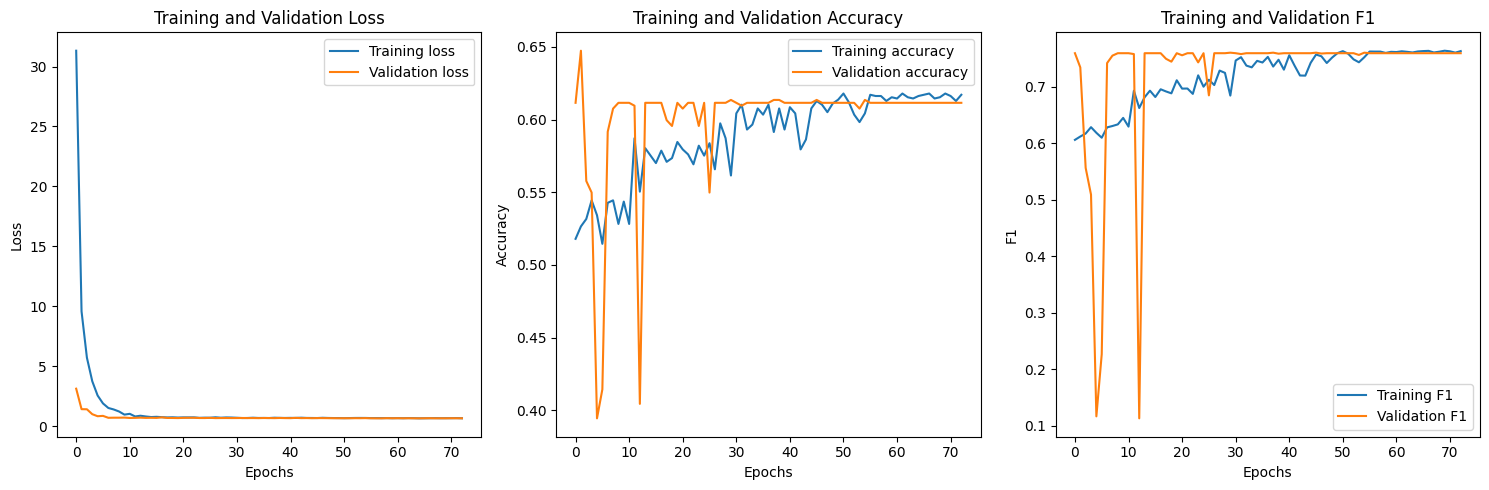

In [57]:
plot_metrics(history_early)

# Predicciones

In [58]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay



In [59]:
y_pred_proba = model_early.predict(X_test)
y_pred_binary = np.where(y_pred_proba >= 0.5, 1, 0)

23/23 [==============================] - 0s 2ms/step


In [60]:

accuracy_score(y_test, y_pred_binary)

0.5899581589958159

In [61]:
print(classification_report(y_test, y_pred_binary))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       294
           1       0.59      1.00      0.74       423

    accuracy                           0.59       717
   macro avg       0.29      0.50      0.37       717
weighted avg       0.35      0.59      0.44       717



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


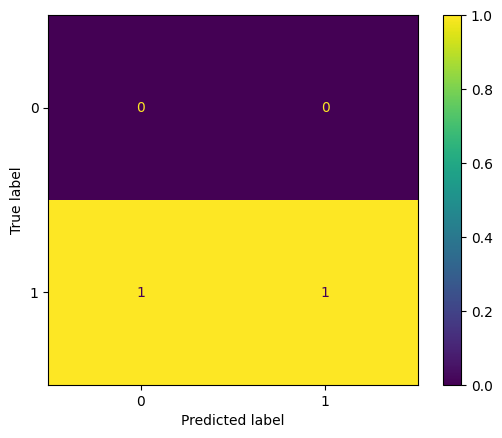

In [62]:
cm = confusion_matrix(y_pred_binary, y_test, normalize = 'pred')
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

plt.show()